# Figures

In [1]:
from pathlib import Path
import warnings

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
import cmocean as cm
import fluxerror
import intake
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
import numpy as np
import pyseaflux as sf
import xarray as xr

from plotting import (
    create_grid,
    add_coastline,
    add_continents,
    add_colorbar,
    add_colorbar_to_subplot,
    add_title,
    plot_data
)

In [2]:
ds = xr.open_dataset("/home/ljg48/project/data/oae-uncertainty-data/fractional-uncertanties-1x1-1993-2022.nc")

In [3]:
ds_mask = xr.open_dataset("/home/ljg48/project/data/lsm/processed/ocean-mask_invariant_1x1.nc")

In [4]:
frac_sol_squared = (ds['frac_sol_sss']**2) + (ds['frac_sol_sst']**2)

In [5]:
frac_kw_squared = (
    (ds['frac_kw_umean']**2) 
    + (ds['frac_kw_ustd']**2)
    + (ds['frac_kw_sc']**2)
) 

In [6]:
frac_flux_squared = frac_sol_squared + frac_kw_squared + ds["frac_pco2"]**2

In [ ]:

# calculate dominant term

ds_out = xr.merge([
    (ds['frac_pco2']**2 / frac_flux_squared ).to_dataset(name = 'perc_pco2'),
    (frac_kw_squared  / frac_flux_squared).to_dataset(name = 'perc_kw'),
    (frac_sol_squared  / frac_flux_squared ).to_dataset(name = 'perc_sol'),
])

ds_avg = ds_out.mean('time')

var_list = list(ds_avg)


#ds_avg['perc_pco2'].where(ds_avg['perc_pco2'] > 0.5)

# concatenate across new dimension
ds_merged = xr.concat([ds_avg[var] for var in var_list], #.where(ds_avg[var] > 0.5)
  dim='ensemble')\
  .assign_coords({"ensemble": var_list})\
  .rename('data')\
  .to_dataset()

data_dominant = ds_merged.fillna(-9999).argmax(dim='ensemble', skipna=True).compute()['data']


In [ ]:

# calculate flux

# read data
data_dir = Path("/home/ljg48/project/data/oae-uncertainty-data/")
ds_wind = xr.open_dataset(data_dir / "wind-1x1-1993-2022.nc")
ds_sst = xr.open_dataset(data_dir / "oisst-1x1-1993-2022.nc")
ds_sss = xr.open_dataset(data_dir / "en4-1x1-1993-2022.nc")
ds_pco2 = xr.open_dataset(data_dir / "pco2-1x1-1993-2022.nc")
ds_slp = xr.open_dataset(data_dir / "era5-slp-1x1-1993-2022.nc")
ds_xco2 = (
    xr.open_dataset('/home/ljg48/project/data/noaa-mbl/processed/noaa-mbl_197901-202301_1x1.nc')
    .sel(time=slice("1993", "2022"))
)

# conversions
atm_per_Pa  = (1 / 101325)
hours_per_day = 24 # hrs / day
m_per_cm = 1/100   # m / cm
atm_per_uatm = (1 / 10**6)  # atm / uatm
liter_per_m3 = 1000 
mmol_per_mol = 1000 
days_per_year = 365
atm_per_uatm = 1 / 1000000

# calculate variables
wind_second_moment = (ds_wind["ws_mean"]**2 + ds_wind["ws_std"]**2).mean("product")
temp_C = ds_sst["sst"]                   # dec.C
temp_K = temp_C + 273.15                 # K
sfco2 = ds_pco2["sfco2"].mean("product") # uatm
xco2 = ds_xco2["xco2"]                   # umol / mol
salt = ds_sss["salinity"]                # PSU
Patm = ds_slp['sp_mean'] * atm_per_Pa    # atm


# calculate gas transfer velocity. unit analysis: kw = (cm . hr-1) * (hr . day-1) . (cm-1 . m)
kw_cmhr = sf.gas_transfer_velocity.k_Wa14(wind_second_moment, temp_C) # cm / hr
kw = kw_cmhr * hours_per_day * m_per_cm  # m / day

# solubility unit analysis:  mol / L / atm --> mol / m3 / atm
sol = sf.solubility.solubility_weiss1974(salt, temp_K) * liter_per_m3  # mol / m3 / atm

# ocean and atmosphere pco2, both in atm
pco2_sea =  sf.fCO2_to_pCO2(fCO2SW_uatm=sfco2, tempSW_C=temp_C ) * atm_per_uatm # atm
pco2_air = xco2 * Patm * atm_per_uatm  # atm

# difference ocean atmosphere pco2
dpco2 = pco2_sea - pco2_air

# (m . day-1) * (mol m3-1 atm-1) * (atm) =  mol * m2-1 * day-1 
Fco2 = kw * sol * dpco2 * days_per_year  # mol / m2 / year

# uncertainty in Fco2
delta_Fco2 = abs(Fco2) * frac_flux_squared**0.5

# Figure 1: fractional uncertainties normalized

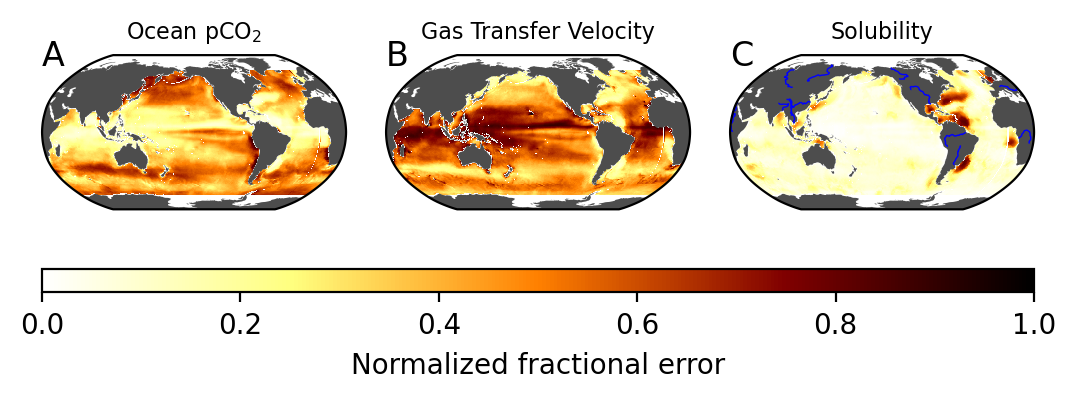

In [77]:
vmin = 0
vmax = 1
cmap = mpl.cm.afmhot_r #cm.cm.haline

fig = plt.figure(dpi=200)

grid = create_grid(fig, axes_pad=0.2, nrows_ncols=(1, 3), cbar_size='5%')


ind = 0
#data = ((frac_sol_squared)).mean('time').where(ds_mask['mask'] == 1)
data1 = ((ds['frac_pco2']**2) / frac_flux_squared ).mean('time').where(ds_mask['mask'] == 1)
#data = ((frac_sol_squared).mean('time').where(ds_mask['mask'] == 1) / (frac_sol_sst**2).mean('time').where(ds_mask['mask'] == 1))
grid = add_continents(grid, ind)
plot_data(grid, ind, data1, vmin=vmin, vmax=vmax, cmap=cmap)
#contour_params = {
#    'transform':ccrs.PlateCarree(central_longitude=0),
#    "levels": [0.75],
#    "colors": "blue",
#    "linestyles": "dashed",
#    "linewidths": 0.3
#    }
#grid[ind].contour(data1.lon, data1.lat, data1, **contour_params)
add_title(grid, ind, title=r'Ocean pCO$_2$', fontsize=8)


# Label 'A'
grid[ind].text(0.0, 1.1, 'A', transform=grid[ind].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')


ind = 1
data2 = (frac_kw_squared  / frac_flux_squared).mean('time').where(ds_mask['mask'] == 1)
#data = ((frac_sol_squared).mean('time').where(ds_mask['mask'] == 1) / (frac_sol_sst**2).mean('time').where(ds_mask['mask'] == 1))
grid = add_continents(grid, ind)
plot_data(grid, ind, data2, vmin=vmin, vmax=vmax, cmap=cmap)
#contour_params = {
#    'transform':ccrs.PlateCarree(central_longitude=0),
#    "levels": [0.5],
#    "colors": "blue",
#    "linestyles": "dashed",
#    "linewidths": 0.3
#    }
#grid[ind].contour(data2.lon, data2.lat, data2, **contour_params)
add_title(grid, ind, title='Gas Transfer Velocity', fontsize=8)


# Label 'B'
grid[ind].text(0.0, 1.1, 'B', transform=grid[ind].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')


ind = 2
data3 = (frac_sol_squared  / frac_flux_squared ).mean('time').where(ds_mask['mask'] == 1)
grid = add_continents(grid, ind)
plot_data(grid, ind, data3, vmin=vmin, vmax=vmax, cmap=cmap)
#contour_params = {
#    'transform':ccrs.PlateCarree(central_longitude=0),
#    "levels": [0.50],
#    "colors": "blue",
#    "linestyles": "dashed",
#    "linewidths": 0.3
#    }
#grid[ind].contour(data3.lon, data3.lat, data3, **contour_params)
add_title(grid, ind, title='Solubility', fontsize=8)

# Add rivers
#grid[ind].add_feature(cfeature.RIVERS)
# Load rivers shapefile from Natural Earth data
rivers_shp = shapereader.natural_earth(resolution='110m',
                                       category='physical',
                                       name='rivers_lake_centerlines')

# Create a feature for rivers with custom linewidth
rivers_feature = cfeature.ShapelyFeature(shapereader.Reader(rivers_shp).geometries(),
                                         ccrs.PlateCarree(), facecolor='none', edgecolor='blue')

# Add rivers with a thin linewidth
grid[ind].add_feature(rivers_feature, linewidth=0.5)  # Adjust linewidth as desired



col = add_colorbar(grid, vmin=vmin, vmax=vmax, cmap=cmap)
col.ax.set_xlabel('Normalized fractional error')


# Label 'C'
grid[ind].text(0.0, 1.1, 'C', transform=grid[ind].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')


plt.savefig('/home/ljg48/project/oae-uncertainty/reports/figures/fractional-uncertainties-normalized.png', bbox_inches='tight')



# Figure 2: Gas trasnfer contribution

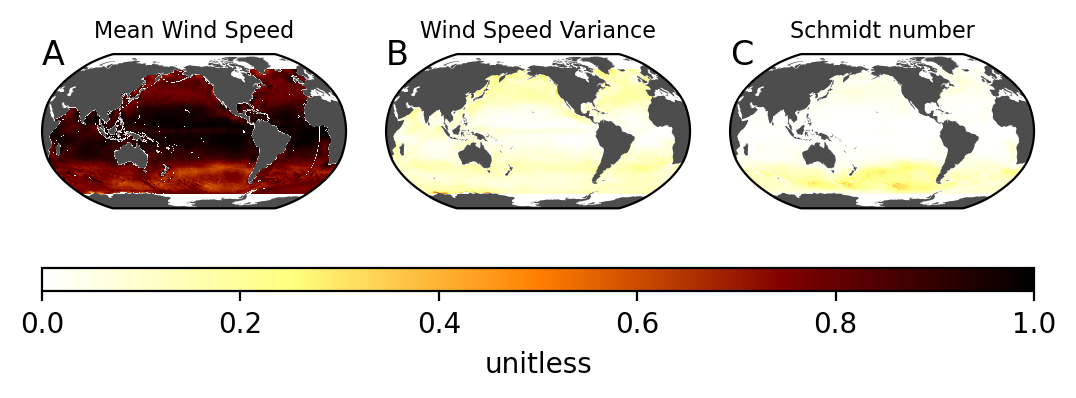

In [76]:
#tmp = xr.open_dataset("/home/ljg48/project/data/ERA5_sp/processed/e5.oper.an.sfc.sp.1x1.1982.nc")

vmin = 0
vmax = 1
cmap = mpl.cm.afmhot_r

fig = plt.figure(dpi=200)

grid = create_grid(fig, axes_pad=0.2, nrows_ncols=(1, 3), cbar_size='5%')


ind = 0
#data = ((frac_sol_squared)).mean('time').where(ds_mask['mask'] == 1)
data = ((ds['frac_kw_umean']**2) / frac_kw_squared).mean('time').where(ds_mask['mask'] == 1)
#data = ((frac_sol_squared).mean('time').where(ds_mask['mask'] == 1) / (frac_sol_sst**2).mean('time').where(ds_mask['mask'] == 1))
grid = add_continents(grid, ind)
plot_data(grid, ind, data, vmin=vmin, vmax=vmax, cmap=cmap)
#contour_params = {
#    'transform':ccrs.PlateCarree(central_longitude=0),
#    "levels": [0.98],
#    "colors": "white",
#    "linestyles": "dashed",
#    "linewidths": 0.5
#    }
#grid[ind].contour(data.lon, data.lat, data, **contour_params)
add_title(grid, ind, title='Mean Wind Speed', fontsize=8)

# Label 'A'
grid[ind].text(0.0, 1.1, 'A', transform=grid[ind].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')


ind = 1
data = ((ds['frac_kw_ustd']**2) / frac_kw_squared).mean('time').where(ds_mask['mask'] == 1)
#data = ((frac_sol_squared).mean('time').where(ds_mask['mask'] == 1) / (frac_sol_sst**2).mean('time').where(ds_mask['mask'] == 1))
grid = add_continents(grid, ind)
plot_data(grid, ind, data, vmin=vmin, vmax=vmax, cmap=cmap)
add_title(grid, ind, title='Wind Speed Variance', fontsize=8)

# Label 'B'
grid[ind].text(0.0, 1.1, 'B', transform=grid[ind].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')


ind = 2
data = ((ds['frac_kw_sc']**2) / frac_kw_squared).mean('time').where(ds_mask['mask'] == 1)
grid = add_continents(grid, ind)
plot_data(grid, ind, data, vmin=vmin, vmax=vmax, cmap=cmap)
add_title(grid, ind, title='Schmidt number', fontsize=8)

#ind = 2
#data = ((frac_sol_squared)/(frac_sol_sss**2)).mean('time').where(ds_mask['mask'] == 1)
#grid = add_continents(grid, ind)
#plot_data(grid, ind, data, vmin=0, vmax=1)
#add_title(grid, ind, title='Ko / SSS', fontsize=8)

col = add_colorbar(grid, vmin=vmin, vmax=vmax, cmap=cmap)
col.ax.set_xlabel('unitless')

# Label 'C'
grid[ind].text(0.0, 1.1, 'C', transform=grid[ind].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')


plt.savefig('/home/ljg48/project/oae-uncertainty/reports/figures/fractional-uncertainties-normalized-gas-transfer.png', bbox_inches='tight')

In [29]:
# make plot of zonal average wind speed for products, show divergence in tropics

# Figure 3: Solubility contribution

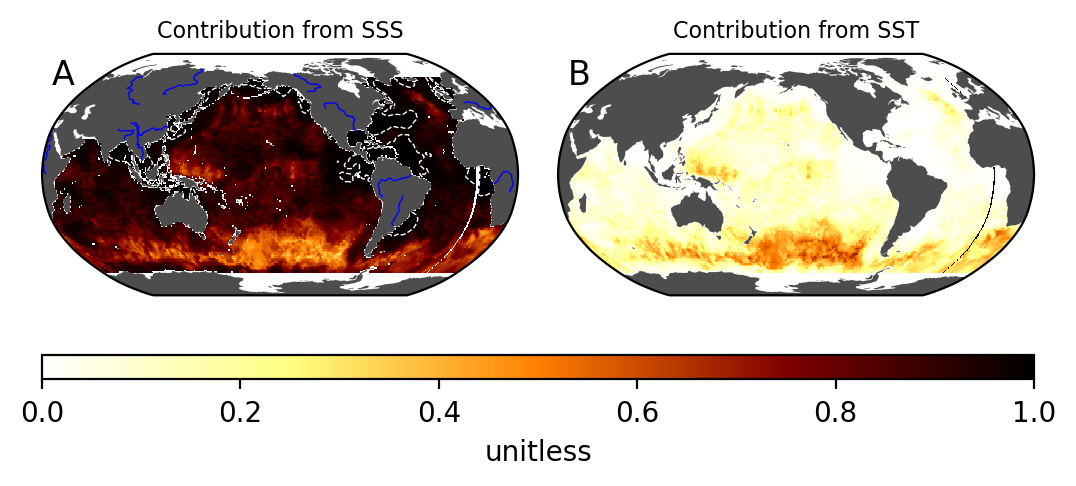

In [70]:
vmin = 0
vmax = 1
cmap = mpl.cm.afmhot_r
#cmap = mpl.cm.gnuplot2_r
#cmap = cm.cm.haline
ncolors = 1

fig = plt.figure(dpi=200)

grid = create_grid(fig, axes_pad=0.2, nrows_ncols=(1, 2), cbar_size='5%')


#ind = 0
#data = ((frac_sol_squared)).mean('time').where(ds_mask['mask'] == 1)
##data = ((frac_sol_squared).mean('time').where(ds_mask['mask'] == 1) / (frac_sol_sst**2).mean('time').where(ds_mask['mask'] == 1))
#grid = add_continents(grid, ind)
#plot_data(grid, ind, data, vmin=vmin, vmax=vmax)
#add_title(grid, ind, title='Solubilty fractional uncertainty', fontsize=8)


ind = 0
data = ((ds['frac_sol_sss']**2) / frac_sol_squared).mean('time').where(ds_mask['mask'] == 1)
grid = add_continents(grid, ind)
plot_data(grid, ind, data, vmin=vmin, vmax=vmax, cmap=cmap, ncolors=ncolors)
contour_params = {
    'transform':ccrs.PlateCarree(central_longitude=0),
    "levels": [0.99],
    "colors": "white",
    "linestyles": "dashed",
    "linewidths": 0.5
    }
grid[ind].contour(data.lon, data.lat, data, **contour_params)
add_title(grid, ind, title='Contribution from SSS', fontsize=8)



# Add rivers
#grid[ind].add_feature(cfeature.RIVERS)
# Load rivers shapefile from Natural Earth data
rivers_shp = shapereader.natural_earth(resolution='110m',
                                       category='physical',
                                       name='rivers_lake_centerlines')

# Create a feature for rivers with custom linewidth
rivers_feature = cfeature.ShapelyFeature(shapereader.Reader(rivers_shp).geometries(),
                                         ccrs.PlateCarree(), facecolor='none', edgecolor='blue')

# Add rivers with a thin linewidth
grid[ind].add_feature(rivers_feature, linewidth=0.5)  # Adjust linewidth as desired


grid[ind].text(0.02, 0.98, 'A', transform=grid[ind].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')


ind = 1
data = ((ds['frac_sol_sst']**2)/ frac_sol_squared).mean('time').where(ds_mask['mask'] == 1)
#data = ((frac_sol_squared).mean('time').where(ds_mask['mask'] == 1) / (frac_sol_sst**2).mean('time').where(ds_mask['mask'] == 1))
grid = add_continents(grid, ind)
plot_data(grid, ind, data, vmin=vmin, vmax=vmax, cmap=cmap, ncolors=ncolors)
add_title(grid, ind, title='Contribution from SST', fontsize=8)



#ind = 2
#data = ((frac_sol_squared)/(frac_sol_sss**2)).mean('time').where(ds_mask['mask'] == 1)
#grid = add_continents(grid, ind)
#plot_data(grid, ind, data, vmin=0, vmax=1)
#add_title(grid, ind, title='Ko / SSS', fontsize=8)

col = add_colorbar(grid, vmin=vmin, vmax=vmax, cmap=cmap, ncolors=ncolors)
col.ax.set_xlabel('unitless')

# Label 'B'
grid[ind].text(0.02, 0.98, 'B', transform=grid[ind].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')


plt.savefig('/home/ljg48/project/oae-uncertainty/reports/figures/fractional-uncertainties-normalized-solubility.png', bbox_inches='tight')

# Figure 4: 
## Flux, flux error, CV, and dominant term

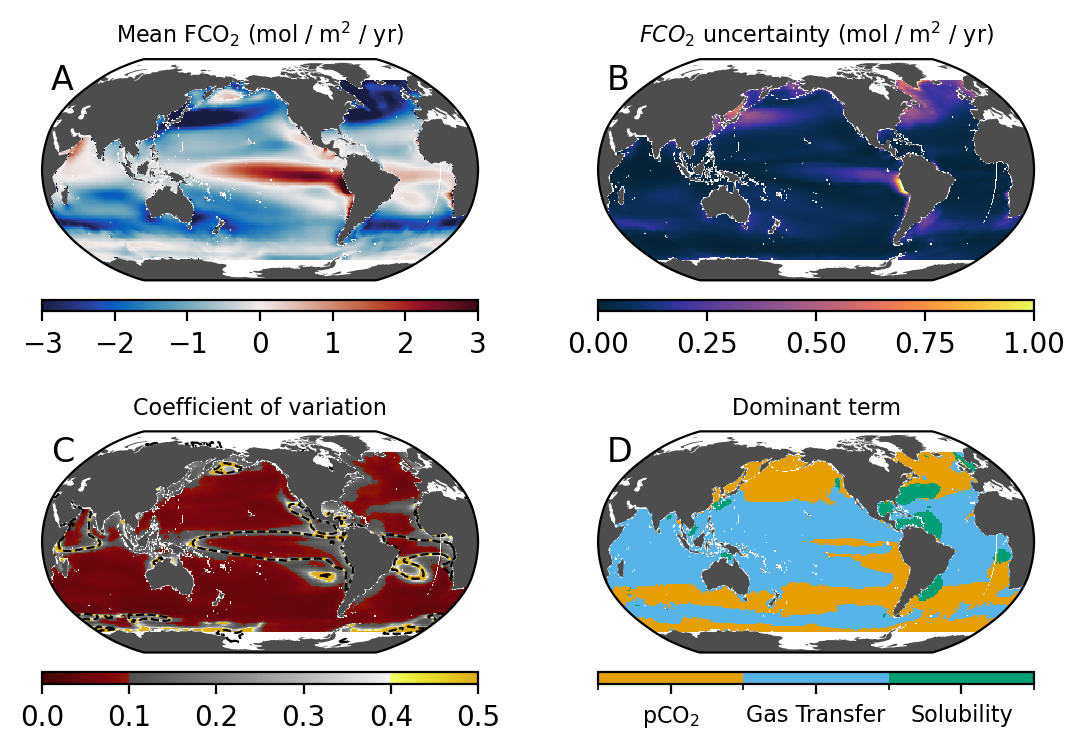

In [69]:
fig = plt.figure(dpi=200)

grid = create_grid(fig, axes_pad=0.6, nrows_ncols=(2, 2), cbar_size='5%', cbar_mode='each')

ind = 0
vmin = -3
vmax = 3
cmap = cm.cm.balance
ncolors = 101
data = Fco2.mean('time').where(ds_mask['mask'] == 1)
grid = add_continents(grid, ind)
plot_data(grid, ind, data, vmin=vmin, vmax=vmax, cmap=cmap)
add_title(grid, ind, title=r'Mean FCO$_2$ (mol / m$^2$ / yr)', fontsize=8)
#col = add_colorbar(grid, vmin=vmin, vmax=vmax, ncolors=ncolors, cmap=cmap)
col = add_colorbar_to_subplot(grid, ind, vmin=vmin, vmax=vmax, ncolors=ncolors, cmap=cmap, ticks=[-3, -2, -1, 0, 1, 2, 3])
#col.ax.set_xlabel(r'mol / m$^2$ / yr')

# Label 'A'
grid[ind].text(0.02, 0.98, 'A', transform=grid[ind].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')

ind = 1
vmin = 0
vmax = 1
cmap = cm.cm.thermal
ncolors = 101
data = abs(delta_Fco2.mean('time').where(ds_mask['mask'] == 1))
grid = add_continents(grid, ind)
plot_data(grid, ind, data, vmin=vmin, vmax=vmax, ncolors=ncolors, cmap=cmap)
add_title(grid, ind, title=r'$FCO_2$ uncertainty (mol / m$^2$ / yr)', fontsize=8)
#col = add_colorbar(grid, vmin=vmin, vmax=vmax, ncolors=ncolors, cmap=cmap)
col = add_colorbar_to_subplot(grid, ind, vmin=vmin, vmax=vmax, ncolors=ncolors, cmap=cmap, ticks=[0, 0.25, 0.5, 0.75, 1])
#col.ax.set_xlabel(r'mol / m$^2$ / yr', fontsize=8)

# Label 'B'
grid[ind].text(0.02, 0.98, 'B', transform=grid[ind].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')


ind = 2
vmin = 0
vmax = 0.5
ncolors=101
cmap = cm.cm.oxy
F =  abs(Fco2.mean('time').where(ds_mask['mask'] == 1))
dF =  abs(delta_Fco2.mean('time').where(ds_mask['mask'] == 1))
data = (dF / F ) 
grid = add_continents(grid, ind)
plot_data(grid, ind, data, vmin=vmin, vmax=vmax, ncolors=ncolors, cmap=cmap)
contour_params = {
    'transform':ccrs.PlateCarree(central_longitude=0),
    "levels": [0],
    "colors": "black",
    "linestyles": "dashed",
    "linewidths": 0.8
    }
grid[ind].contour(Fco2.lon, Fco2.lat, Fco2.mean("time"), **contour_params)
add_title(grid, ind, title=r'Coefficient of variation', fontsize=8)
#add_title(grid, ind, title=r'Coefficient of variation', fontsize=8)
col = add_colorbar_to_subplot(grid, ind, vmin=vmin, vmax=vmax, ncolors=ncolors, cmap=cmap)

# Specify specific ticks
#ticks = [vmin, (vmin + vmax) / 2, vmax]
#add_colorbar_to_subplot(grid, ind, vmin, vmax, ticks=ticks, label="My Colorbar Label")
#col.ax.set_xlabel('Coefficient of variation')


# Define the colors
colors = ['#E69F00', '#56B4E9', '#009E73']

# Create a color map
cmap_name = 'custom_color_map'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors)


# Label 'C'
grid[ind].text(0.02, 0.98, 'C', transform=grid[ind].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')



ind = 3
vmin = 0
vmax = 2
ncolors=3

#data = data.where(ds_mask['mask'] == 1)
data = data_dominant.where(ds_mask['mask'] == 1)
grid = add_continents(grid, ind)
plot_data(grid, ind, data, vmin=vmin, vmax=vmax, ncolors=ncolors, cmap=cmap)
add_title(grid, ind, title=r'Dominant term', fontsize=8)


# Define the boundaries for the colors
bounds = [0, 1, 2, 3]  # In this case, we have 3 colors

# Create a normalization instance to scale data to the interval [0,1]
norm = BoundaryNorm(bounds, cmap.N)

# Create a colorbar with discrete colors
cbar = grid.cbar_axes[ind].colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ticks=np.arange(0.5, 3, 1))
#col = add_colorbar_to_subplot(grid, ind, vmin=vmin, vmax=vmax, ncolors=ncolors, cmap=cmap)
cbar.set_ticklabels([r'pCO$_2$', 'Gas Transfer', 'Solubility'], fontsize=8)


# Label 'D'
grid[ind].text(0.02, 0.98, 'D', transform=grid[ind].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')

plt.savefig('/home/ljg48/project/oae-uncertainty/reports/figures/flux-cv-dominant-term.png', bbox_inches='tight')


In [15]:
grid = create_grid(fig, axes_pad=0.2, nrows_ncols=(2, 2), cbar_size='5%', cbar_mode='each')
